In [93]:
from sklearn.metrics import mean_squared_error as MSE
import numpy as np
import pandas as pd
import tensorflow as tf
import json
import os
import time
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
from tensorflow.keras.models  import Sequential
from tensorflow.keras.layers import LSTM, Dropout,Dense

from sklearn.preprocessing import StandardScaler

In [3]:
data_path = '/Users/will/Desktop/workspace/Econ1680/project1-wjaekle/data'
with open(f"{data_path}/dictionaries/ID_to_name.json", 'r') as f:
    id2name = json.load(f)
with open(f'{data_path}/dictionaries/name_to_ID.json', 'r') as f:
    name2id = json.load(f)
hp = pd.read_csv(f"{data_path}/1hdata/avgHighPrice.csv")
lp = pd.read_csv(f"{data_path}/1hdata/avgLowPrice.csv")
hv = pd.read_csv(f"{data_path}/1hdata/highPriceVolume.csv")
lv = pd.read_csv(f"{data_path}/1hdata/lowPriceVolume.csv")

In [4]:
#take a weighted average of the prices to get overall avrg price
weighted_avg = ((hp.values*hv.values)+(lp.values*lv.values))/(lv.values+hv.values)
df = pd.DataFrame(columns = hp.columns, data = weighted_avg)
totv = pd.DataFrame(columns = hp.columns, data = (lv.values+hv.values)) #a dataframe of volume traded that day


In [5]:
df = df.interpolate(method = "linear")  #fill in nans if they can be filled in- maybe set a max here in future

In [50]:
prices = df[str(name2id["Abyssal whip"])].to_list() #lists of time and value
times = df["timestamps"].to_list()

In [51]:
window_size = 60 #how far our model will see into the past
X = []
ys = []
for i in range(0,len(prices)-60): #make a list of ys and a list of lists each corresponding to teh previous 60 days
    x = prices[i:i+60]
    y = prices[i+60]
    X.append(x)
    ys.append(y)
X = np.array(X)
y = np.array(ys)
y = np.reshape(y, (len(ys),1)) #shape into column vector


In [53]:
print(y.shape)
print(X.shape)

(8702, 1)
(8702, 60)


In [8]:
#splitting our data into train val test. 

#percentage splits
train_size = .7
test_size = .15
valid_size = .15

#number of splits
test_size = int(.15* X.shape[0])
val_size = int(.15* X.shape[0])
train_size = int(X.shape[0] - test_size-val_size)

#split with slices:
X_train = X[:train_size,:]
X_val = X[train_size:train_size+val_size,:]
X_test = X[train_size+val_size:,:]

y_train = y[:train_size,:]
y_val = y[train_size:train_size+val_size,:]
y_test = y[train_size+val_size:,:]

#make sure we get all the data in there:
assert(X_train.shape[0]+X_test.shape[0]+X_val.shape[0] == X.shape[0])


In [9]:
scaler = StandardScaler()
X_train_prep = scaler.fit_transform(X_train)
X_val_prep = scaler.transform(X_val)
X_test_prep = scaler.transform(X_test)

In [10]:
X_train_prep = X_train_prep.reshape(X_train_prep.shape[0],X_train_prep.shape[1],1)
X_val_prep = X_val_prep.reshape(X_val_prep.shape[0],X_val_prep.shape[1],1)
X_test_prep = X_test_prep.reshape(X_test_prep.shape[0],X_test_prep.shape[1],1)

In [54]:
print(X_train_prep.shape,y_train.shape)

(6092, 60, 1) (6092, 1)


In [25]:
histories = []
params = []
goodparams = []
good_losses = []

In [85]:
units = 1000
con = .3
leaky = .75
sr = .7
dense1 = 200
lr = .002

params.append([units,con,leaky,rs,dense1,lr])
histories.append(0)
model = Sequential()
model.add(tfa.layers.ESN(units, connectivity = con, leaky = leaky, spectral_radius = sr, activation = 'tanh'))#, return_sequences = True ))
model.add(tf.keras.layers.Dense(dense1, activation="relu"))
model.add(tf.keras.layers.Dense(100))
model.add(tf.keras.layers.Dense(50))
#model.add(Dropout(0.2))
model.add(tf.keras.layers.Dense(1))
opt = tf.keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt,loss='mean_squared_error')
history = model.fit(X_train_prep,y_train,epochs=20,batch_size=24)
histories[-1] = history.history['loss']
if history.history['loss'][-1] < 1e9:
    print(params[-1])
    goodparams.append(params[-1])
    good_losses.append(histories[-1])

Epoch 1/20
254/254 [==============================] - 15s 18ms/step - loss: 2621276160000.0000
Epoch 2/20
254/254 [==============================] - 5s 18ms/step - loss: 1132989251584.0000
Epoch 3/20
254/254 [==============================] - 5s 18ms/step - loss: 1063522140160.0000
Epoch 4/20
254/254 [==============================] - 5s 18ms/step - loss: 896095617024.0000
Epoch 5/20
254/254 [==============================] - 5s 18ms/step - loss: 204424134656.0000
Epoch 6/20
254/254 [==============================] - 5s 18ms/step - loss: 94605672.0000
Epoch 7/20
254/254 [==============================] - 5s 18ms/step - loss: 71939024.0000
Epoch 8/20
254/254 [==============================] - 5s 18ms/step - loss: 69107192.0000
Epoch 9/20
254/254 [==============================] - 5s 18ms/step - loss: 69238072.0000
Epoch 10/20
254/254 [==============================] - 5s 18ms/step - loss: 68674544.0000
Epoch 11/20
254/254 [==============================] - 5s 18ms/step - loss: 70054232.

In [101]:
units = [800,1000]
connectivity = [.1,.2,.3]
radius_set = [.2,.3, 0.5, .9 ,1.2]
leakies = [.75,1]
learning_rate = [.01,.005,.003]
dense1 = [100]


histories = []
params = []
best_params = None
best_model = None
best_MSE = 1e12

for unit in units:
    for con in connectivity:
        print(con)
        for leak in leakies:
            for sr in radius_set:
                print(sr)
                for lr in learning_rate:
                    for d in dense1:
                        params.append([unit,con,leak,sr,lr,d])
                        histories.append(0)
                        model = Sequential()
                        model.add(tfa.layers.ESN(unit, connectivity = con, leaky = leak, spectral_radius = sr, activation = 'tanh'))#, return_sequences = True ))
                        model.add(tf.keras.layers.Dense(d, activation="relu"))
                        model.add(tf.keras.layers.Dense(100, activation = "relu"))
                        model.add(tf.keras.layers.Dense(50, activation = "relu"))

                        model.add(tf.keras.layers.Dense(1))
                        opt = tf.keras.optimizers.Adam(learning_rate=lr)
                        model.compile(optimizer=opt,loss='mean_squared_error')
                        history = model.fit(X_train_prep,y_train,epochs=15,batch_size=24)
                        if history.history['loss'][-1] <100_000_000:
                            x_val_preds = model.predict(X_val_prep)
                            loss = MSE(x_val_preds[:,], y_val)
                            if loss < best_MSE:

                                best_params = [unit,con,leak,sr,lr,d]
                                best_model = model
                                best_MSE = loss
                                print(f"{loss = }")
                                print(f"{best_params = }")


0.1
0.2
Epoch 1/15
254/254 [==============================] - 10s 17ms/step - loss: 1767620739072.0000
Epoch 2/15
254/254 [==============================] - 4s 17ms/step - loss: 276791721984.0000
Epoch 3/15
254/254 [==============================] - 4s 17ms/step - loss: 76267216.0000
Epoch 4/15
254/254 [==============================] - 4s 17ms/step - loss: 74921032.0000
Epoch 5/15
254/254 [==============================] - 4s 17ms/step - loss: 75445200.0000
Epoch 6/15
254/254 [==============================] - 4s 17ms/step - loss: 81565808.0000
Epoch 7/15
254/254 [==============================] - 4s 17ms/step - loss: 85013480.0000
Epoch 8/15
254/254 [==============================] - 4s 18ms/step - loss: 106388648.0000
Epoch 9/15
254/254 [==============================] - 4s 17ms/step - loss: 101308088.0000
Epoch 10/15
254/254 [==============================] - 4s 17ms/step - loss: 133058144.0000
Epoch 11/15
254/254 [==============================] - 4s 17ms/step - loss: 141543264.00

In [64]:
print(X_val_prep.shape)
print(preds.shape)

(1305, 60, 1)
(1305, 1)


In [103]:
preds = best_model.predict(X_test_prep)

In [104]:
MSE(preds,y_test)

106242769.43810375

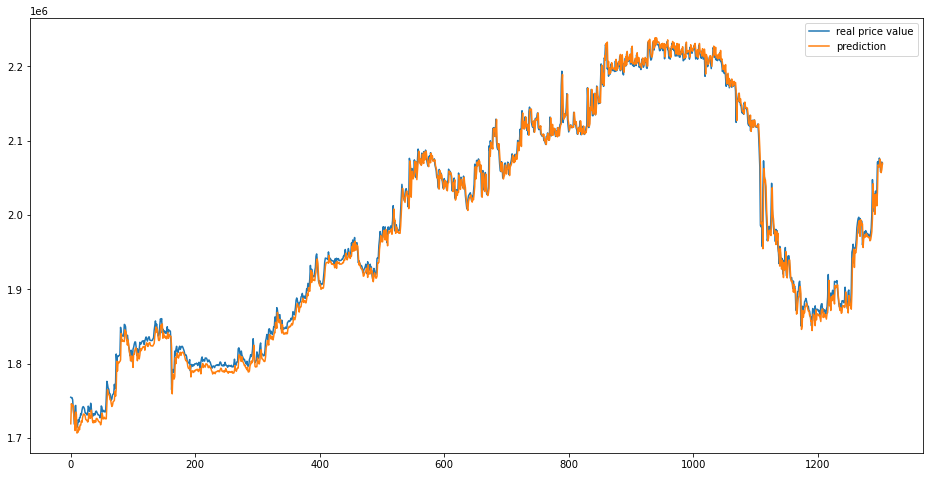

In [73]:
plt.figure(figsize=(16,8))

plt.plot(y_val,label = "real price value")
plt.plot(preds[:,], label = "prediction")

#plt.vlines(x=train_size, ymin=1.5e6, ymax=2.5e6, colors='green', ls=':', lw=2,label='validation set begins')
plt.legend()

plt.show()